# 1.1 - Univariate Gaussianization

In [3]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [4]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# get data
n_samples = 1_000
n_features = 1
data = get_classic(n_samples)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


<AxesSubplot:>

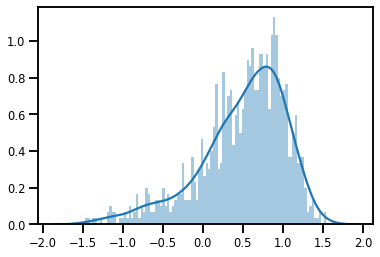

In [6]:
X = np.array(data[:, 1], dtype=np.float32)

sns.distplot(X, bins=100)

In [48]:
X.shape

(1000,)

### Spline Function

In [7]:
from rbig_jax.transforms.parametric.splines import rational_quadratic_spline

In [9]:
seed = 123
KEY = jax.random.PRNGKey(seed)

In [106]:
import jax.numpy as jnp

In [108]:
data_rng, *spline_rng = jax.random.split(KEY, 4)

n_samples = 10_000
n_features = 10

x = jax.random.normal(data_rng, shape=(n_samples, n_features))

# create weight
n_bins = 16
bounds = 10.

widths = jnp.sort(jax.random.normal(spline_rng[0], shape=(1, n_features, n_bins)))
heights = jnp.sort(jax.random.normal(spline_rng[1],  shape=(1, n_features, n_bins)))
derivatives = jnp.sort(jax.random.normal(spline_rng[2],  shape=(1, n_features, n_bins)))

# create layer
z, logabsdet = rational_quadratic_spline(
    x, widths, heights, derivatives, bounds, inverse=False, 
)
chex.assert_equal_shape([z, x])
z.shape, logabsdet.shape
x_approx, _ = rational_quadratic_spline(
        z, widths, heights, derivatives, bounds, inverse=True
    )

chex.assert_tree_all_close(x, x_approx)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
Error in value equality check: Values not approximately equal
Mismatched elements: 99594 / 100000 (99.6%)
Max absolute difference: 25037.803
Max relative difference: 1.3770207
 x: array([[-1.193137,  1.639929,  0.761253, ..., -2.324795, -0.220435,
        -0.236637],
       [ 0.021258, -0.108828,  0.461752, ..., -0.14064 ,  0.523068,...
 y: array([[-10.948106, -10.376249, -11.44451 , ..., -13.518981, -14.369827,
        -12.174114],
       [-10.503688, -10.386946, -11.439759, ..., -13.53829 , -14.364604,...

In [81]:
data_rng, *spline_rng = jax.random.split(KEY, 2)

n_samples = 1
n_features = 10

x = jax.random.normal(data_rng, shape=(n_samples, n_features))

# create weight
n_bins = 16

widths = jax.random.normal(spline_rng[0], shape=(5, n_features, n_bins))
heights = jax.random.normal(spline_rng[0],  shape=(5, n_features, n_bins,))
derivatives = jax.random.normal(spline_rng[0],  shape=(5, n_features, n_bins,))


# create layer
z, logabsdet = rational_quadratic_spline(
    x, widths, heights, derivatives, 20, inverse=False
)
z.shape, logabsdet.shape
x_approx, _ = rational_quadratic_spline(
        z, widths, heights, derivatives, 20, inverse=True
    )

chex.assert_tree_all_close(x, x_approx)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
Error in value equality check: Values not approximately equal
(shapes (1, 10), (5, 10) mismatch)
 x: array([[-0.598748,  0.392628,  0.617442, -1.627917, -0.207408, -0.404104,
         0.218774,  1.596748,  0.152742,  0.495239]], dtype=float32)
 y: array([[-15.1034  , -20.9471  , -21.183216, -21.562899, -23.73013 ,
        -17.147442,        nan, -11.328002, -13.509113, -14.18919 ],
       [-24.889734, -24.653074, -10.66212 , -19.054983, -14.639556,...

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
Error in value equality check: Values not approximately equal
(shapes (1, 10), (5, 10) mismatch)
 x: array([[-0.598748,  0.392628,  0.617442, -1.627917, -0.207408, -0.404104,
         0.218774,  1.596748,  0.152742,  0.495239]], dtype=float32)
 y: array([[ -4.915896, -10.911825, -11.158394, -11.545046, -13.709735,
         -7.638602,        nan,   0.935633, -17.191313,  -3.484936],
       [-14.888687, -14.624612,   0.617441,  -8.990351,  -4.629937,...

In [67]:
# create layer
z, logabsdet = rational_quadratic_spline(
    X[:, None], widths, heights, derivatives, 10, inverse=False
)
z.shape, logabsdet.shape

((1000, 2), (1000,))

<AxesSubplot:>

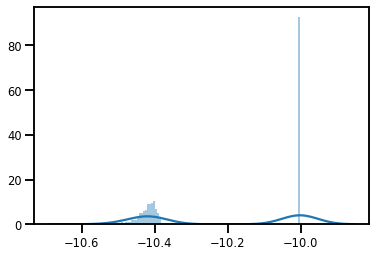

In [54]:
sns.distplot(z, bins=100)

In [23]:
z.shape

(100, 2)

## Histogram Uniformization

In [5]:
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.kde import InitKDEUniformize

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_transform_func, forward_f, grad_f, inverse_f = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

#### Initialize + Forward Transform

In [6]:
X_u, params = init_transform_func(X)

<AxesSubplot:>

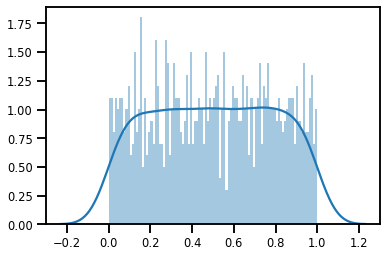

In [7]:
sns.distplot(X_u, bins=100)

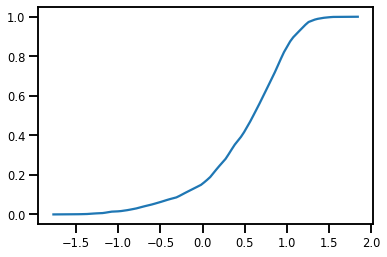

In [8]:
plt.plot(params.support, params.quantiles)

#### JIT

In [9]:
# JIT Compile (OPTIONAL)
# init_f_jitted = jax.jit(init_transform_func)

In [10]:
# X_u, hist_params = init_transform_func(X) 
# %timeit init_transform_func(X.block_until_ready())
# %timeit init_f_jitted(X.block_until_ready()) 

### Forward Transformation

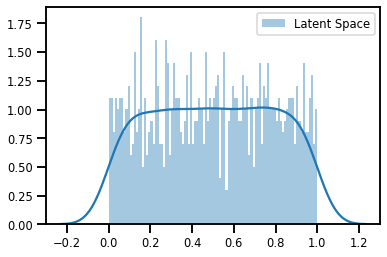

In [11]:
X_u = forward_f(params, X)

sns.distplot(X_u, bins=100, label="Latent Space")
plt.legend()

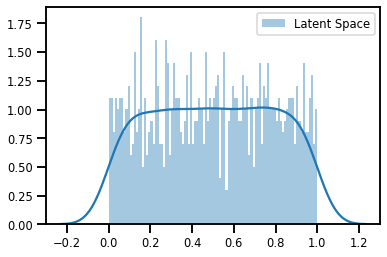

In [12]:
sns.distplot(X_u, bins=100, label="Latent Space")
plt.legend()

### Inverse Transformation

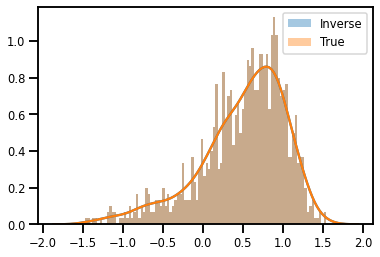

In [13]:
X_approx = inverse_f(params, X_u)


sns.distplot(X_approx, bins=100, label="Inverse")
sns.distplot(X, bins=100, label="True")
plt.legend()

### Jacobian

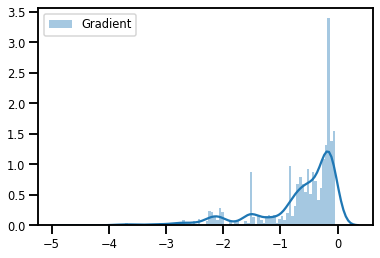

In [14]:
X_g, X_ldj_u = grad_f(params, X)


plt.figure()
sns.distplot(X_ldj_u, bins=100, label="Gradient")
plt.legend()
plt.show()

## Inverse CDF Estimation

In [15]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_transform_func, forward_f, grad_f, inverse_f = InitInverseGaussCDF(eps=eps)

### Forward Transform

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


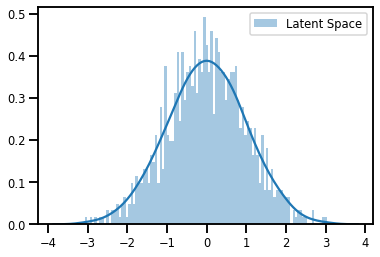

In [16]:
X_g, params = init_transform_func(X_u)

plt.figure()
sns.distplot(X_g, bins=100, label="Latent Space")
plt.legend()
plt.show()

### Inverse Transform

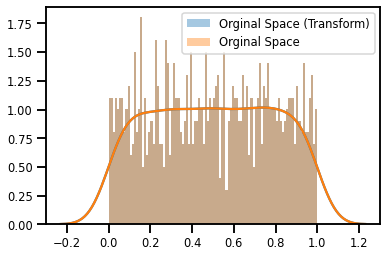

In [17]:
X_u_approx = inverse_f(params, X_g)

plt.figure()
sns.distplot(X_u_approx, bins=100, label="Orginal Space (Transform)")
sns.distplot(X_u, bins=100, label="Orginal Space")
plt.legend()
plt.show()

### Gradient Transform

In [18]:
X_g, X_ldj_g = grad_f(params, X_u)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


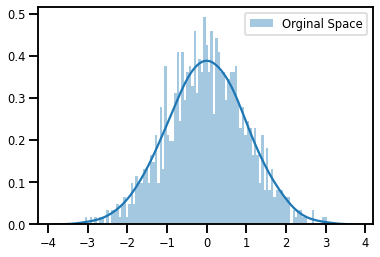

In [19]:
plt.figure()
sns.distplot(X_g, bins=100, label="Orginal Space")
plt.legend()
plt.show()

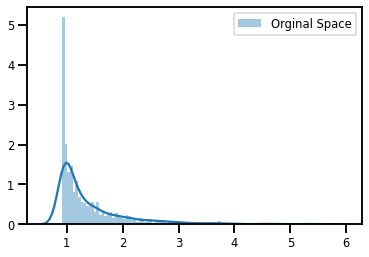

In [20]:
plt.figure()
sns.distplot(X_ldj_g, bins=100, label="Orginal Space")
plt.legend()
plt.show()

In [21]:
log_prob = jax.scipy.stats.norm.logpdf(X_g)

log_prob += X_ldj_u + X_ldj_g

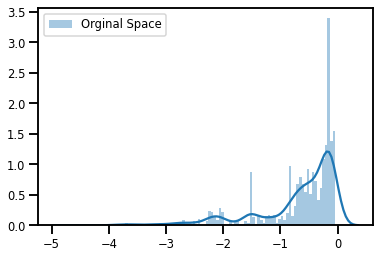

In [22]:
plt.figure()
sns.distplot(log_prob, bins=100, label="Orginal Space")
plt.legend()
plt.show()

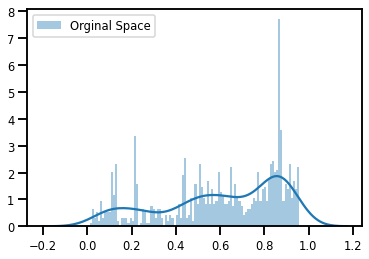

In [23]:
prob = np.exp(log_prob)

plt.figure()
sns.distplot(prob, bins=100, label="Orginal Space")
plt.legend()
plt.show()